In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
# import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from uitils import *
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, auc

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# Data Loading

In [4]:
creditcard_path =get_full_path('../datasets/creditcard.csv')
# fraudulent=1 
# unlabeled=0
creditcard_df = pd.read_csv(creditcard_path)
x_train = creditcard_df.drop('Class', axis=1) 
y_train = creditcard_df['Class']

# Separate the positive and negative instances
positives = creditcard_df[creditcard_df['Class'] == 1]
negatives = creditcard_df[creditcard_df['Class'] == 0]

# Randomly sample negative examples
neg_sample = negatives.sample(n=500, random_state=42)

# Concatenate the positive examples with the sampled negative examples
sampled_df = pd.concat([positives, neg_sample])

# Shuffle the dataset to mix up the rows
sampled_df = sampled_df.sample(frac=1, random_state=42)

# Split the features and labels
x_train_sampled = sampled_df.drop('Class', axis=1)
y_train_sampled = sampled_df['Class']

# Split into training and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_train_sampled, y_train_sampled, test_size=0.1, random_state=42)
s=y_train
# Print the training labels distribution to verify
print("Training labels distribution:", np.bincount(y_train))
print("Testing labels distribution:", np.bincount(y_test))

Training labels distribution: [455 437]
Testing labels distribution: [45 55]


In [5]:
print("x_train shape:", x_train.shape)
print("y_test shape:", y_test.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)


x_train shape: (892, 30)
y_test shape: (100,)
x_test shape: (100, 30)
y_train shape: (892,)


# Pre-training

In [8]:
weight_decay = 2.0
model_1 = Sequential([
    Dense(96, input_shape=(30,), kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    Dense(192, kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    Dense(10, kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    Dense(100, kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    Dense(100, kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    Dense(1, kernel_regularizer=l2(weight_decay)),
    Activation('sigmoid')
])


model_1.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.2)
# model_1.save_weights('clf_model_.weights.h5')
# model_1.load_weights('clf_model_.weights.h5')


Epoch 1/15
6/6 [==============================] - 3s 116ms/step - loss: 1093.4564 - accuracy: 0.4839 - val_loss: 1019.2999 - val_accuracy: 0.5140
Epoch 2/15
6/6 [==============================] - 0s 67ms/step - loss: 1036.1368 - accuracy: 0.4839 - val_loss: 967.9972 - val_accuracy: 0.5140
Epoch 3/15
6/6 [==============================] - 0s 67ms/step - loss: 979.3001 - accuracy: 0.4839 - val_loss: 917.1761 - val_accuracy: 0.5140
Epoch 4/15
6/6 [==============================] - 0s 67ms/step - loss: 924.2989 - accuracy: 0.4839 - val_loss: 867.4931 - val_accuracy: 0.5140
Epoch 5/15
6/6 [==============================] - 0s 68ms/step - loss: 872.3875 - accuracy: 0.4839 - val_loss: 820.7644 - val_accuracy: 0.5140
Epoch 6/15
6/6 [==============================] - 0s 69ms/step - loss: 819.7162 - accuracy: 0.4839 - val_loss: 773.4044 - val_accuracy: 0.5140
Epoch 7/15
6/6 [==============================] - 0s 68ms/step - loss: 768.3580 - accuracy: 0.4839 - val_loss: 726.4063 - val_accuracy: 0.

### Probablistic outcome of classifer to pre-train policy network
 

28/28 [==============================] - 0s 7ms/step
Classifer predicted labels distribution: [  3 889]


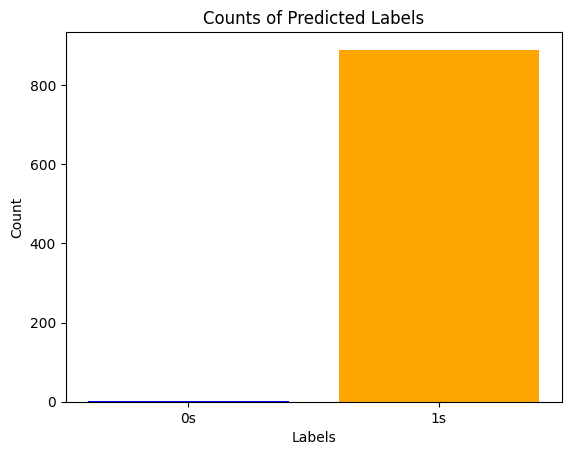

In [9]:
probabilities = model_1.predict(x_train)
threshold = min(probabilities[y_train == 1])

# Convert probabilities to binary labels based on the threshold
predicted_labels = (probabilities >= threshold).astype(int)
clf_predicted_labels = predicted_labels.flatten().astype(int)

print("Classifer predicted labels distribution:", np.bincount(clf_predicted_labels))
# bin_ploter(predicted_labels=clf_predicted_labels)

In [10]:
# Policy-Network Model
class PolicyGradientNetwork:
    def __init__(self):
        self.model = self._create_model()
    
    def _create_model(self):
        weight_decay = 0.5
        model = Sequential([
            Dense(96, input_shape=(30,), kernel_regularizer=l2(weight_decay)),
            Activation('relu'),
            Dense(192, kernel_regularizer=l2(weight_decay)),
            Activation('relu'),
            Dense(10, kernel_regularizer=l2(weight_decay)),
            Activation('relu'),
            Dense(100, kernel_regularizer=l2(weight_decay)),
            Activation('relu'),
            Dense(1, kernel_regularizer=l2(weight_decay)),  # Sigmoid output for binary classification
            Activation('sigmoid')
        ])
        return model
    
    def get_model(self):
        return self.model
    

policy_network = PolicyGradientNetwork()
pn_model = policy_network.get_model()

pn_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

history_2 = pn_model.fit(x_train, clf_predicted_labels, epochs=15, batch_size=128, validation_split=0.2)
# pn_model.save_weights('pn_model_.weights.h5')
# pn_model.load_weights('pn_model_.weights.h5')

Epoch 1/15
6/6 [==============================] - 1s 116ms/step - loss: 109.6206 - accuracy: 0.9972 - val_loss: 133.4595 - val_accuracy: 0.9888
Epoch 2/15
6/6 [==============================] - 0s 64ms/step - loss: 109.4100 - accuracy: 0.9972 - val_loss: 132.3152 - val_accuracy: 0.9888
Epoch 3/15
6/6 [==============================] - 0s 63ms/step - loss: 109.2189 - accuracy: 0.9972 - val_loss: 131.2984 - val_accuracy: 0.9888
Epoch 4/15
6/6 [==============================] - 0s 65ms/step - loss: 108.9620 - accuracy: 0.9972 - val_loss: 130.5446 - val_accuracy: 0.9888
Epoch 5/15
6/6 [==============================] - 0s 64ms/step - loss: 108.8012 - accuracy: 0.9972 - val_loss: 129.5985 - val_accuracy: 0.9888
Epoch 6/15
6/6 [==============================] - 0s 63ms/step - loss: 108.6004 - accuracy: 0.9972 - val_loss: 128.6662 - val_accuracy: 0.9888
Epoch 7/15
6/6 [==============================] - 0s 63ms/step - loss: 108.4298 - accuracy: 0.9972 - val_loss: 127.6510 - val_accuracy: 0.988

28/28 [==============================] - 0s 6ms/step
Classifer predicted labels distribution: [  0 892]


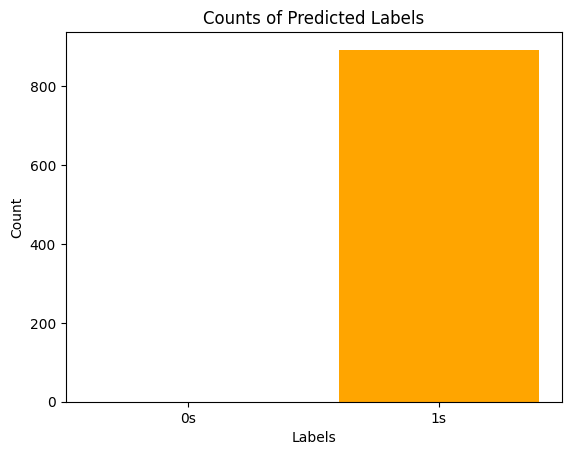

In [11]:
probabilities = pn_model.predict(x_train)
threshold = min(probabilities[y_train == 1])

# Convert probabilities to binary labels based on the threshold
predicted_labels = (probabilities >= threshold).astype(int)
np_predicted_labels = predicted_labels.flatten().astype(int)

print("Classifer predicted labels distribution:", np.bincount(np_predicted_labels))
bin_ploter(predicted_labels=np_predicted_labels)

## Interactive learning

In [12]:
import tensorflow as tf
import numpy as np

class Agent:
    def __init__(self, model, target_model, alpha=0.00001, gamma=0.99):
        self.gamma = gamma  # Discount factor
        self.lr = alpha  # Learning rate
        self.model = model  # Policy model
        self.target_model = target_model # target policy model
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

    def choose_action(self, states, s, threshold=0.5):
        # Convert states to float32 tensor within the function
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        probabilities = self.target_model(states)  # Make sure target model expects float32 input
        # action_sampler = tfp.distributions.Bernoulli(probs=probabilities, dtype=tf.float32)
        # actions = action_sampler.sample()
        # print(f"probabilities ={probabilities}")
        # actions = tf.cast(tf.random.uniform(tf.shape(probabilities)) < probabilities, tf.int32)

        inferred_labels = tf.cast(probabilities > threshold, tf.int32)       
        s = tf.reshape(s, tf.shape(inferred_labels))  # Ensuring s is the same shape as inferred_labels
        actions = tf.where(s == 1, 1, inferred_labels)
        actions = tf.squeeze(actions)  # This should correctly squeeze actions to shape (128,)
        return actions.numpy(), probabilities.numpy()


    def store_transition(self, states, actions, rewards):
        self.state_memory.extend(states)
        self.action_memory.extend(actions)
        self.reward_memory.extend(rewards)

    def learn(self):
        actions = np.array(self.action_memory)
        rewards = np.array(self.reward_memory)
        states = np.array(self.state_memory)

        # Calculate discounted rewards
        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards)):
                G_sum += rewards[k] * discount
                discount *= self.gamma
            G[t] = G_sum

        # Updating policy
        with tf.GradientTape() as tape:
            loss = 0
            for idx, (g, state) in enumerate(zip(G, states)):
                state = tf.convert_to_tensor([state], dtype=tf.float32)
                probs = self.model(state, training=True)
                # action_probs = tfp.distributions.Bernoulli(probs=probs)
                # log_prob = action_probs.log_prob(actions[idx])
                # loss += -g * tf.reduce_sum(log_prob)
                action_probs = tf.where(actions[idx] == 1, probs, 1 - probs)
                log_prob = tf.math.log(action_probs)
                loss += -g * tf.reduce_sum(log_prob)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # Clear memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []


In [13]:
# Clone policy model for stable target policy
target_policy_model = tf.keras.models.clone_model(pn_model)
target_policy_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

history = {
    'epoch_loss': [],
    'epoch_accuracy': [],
    'batch_loss': [],
    'batch_accuracy': [],
    'predictions': [],
    'rewards': [],
    'thresholds': [],
    'ROC_AUC': [],
    'accuracy':[],
    'PR_AUC':[]
}
agent = Agent(pn_model,target_model=target_policy_model, alpha=0.00001, gamma=0.99)
# Example parameters
n_epochs = 300
n_epochs = 10
batch_size = 128 # You can adjust the batch size as needed

def shuffle_data(x_train, y_train, s):
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    return x_train[indices], y_train[indices], s[indices]

def create_mini_batches(x_train, y_train, s, batch_size):
    for start_idx in range(0, len(x_train) - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield x_train[excerpt], y_train[excerpt], s[excerpt]

def calculate_threshold(clf_probabilities, y_batch):
    # Identify indices of positive examples
    positive_indices = (y_batch == 1)
    
    # Calculate threshmin from positive examples
    if np.any(positive_indices):
        threshmin = np.min(clf_probabilities[positive_indices])
    else:
        threshmin = 0  # Default value if no positive examples are present

    # Identify U0 - samples with predictions >= threshmin
    U0_indices = (clf_probabilities >= threshmin)
    
    # Calculate the final threshold using Equation 5
    if np.any(U0_indices):
        threshold = np.mean(clf_probabilities[U0_indices])
    else:
        threshold = threshmin  # Use threshmin if no samples meet the U0 criteria

    return threshold

def calculate_rewards(clf_probabilities, y_batch, threshold):
    # Reward calculation needs to consider whether predictions meet a certain threshold
    # Positive examples above threshold or negative examples below threshold get positive rewards
    rewards = []
    for prob, actual in zip(clf_probabilities.flatten(), y_batch):
        if actual == 1 or (actual == 0 and prob >= threshold):
            reward = prob  # Reward is the probability itself if conditions are met
        else:
            reward = prob -1  # Otherwise, reward is the complement of the probability
        rewards.append(reward)
    return rewards

In [14]:
def train_model(x_train, y_train, s, epochs=300, batch_size=128, min_delta=0.0001, patience=10):
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    s = s.astype('float32')

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, s))
    dataset = dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

    # early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, min_delta=min_delta, mode='max', restore_best_weights=True, verbose=1)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_loss = 0
        epoch_accuracy = 0
        batch_count = 0
        # first_iteration = True
        # threshold_pass = 0.5
        threshold = 0.5
        for x_batch, y_batch, s_batch in dataset:
            # Get actions and probabilities for the entire batch
            actions, probabilities = agent.choose_action(x_batch, s_batch, threshold=threshold)

            # Fit the model on the current batch and update history
            batch_history = model_1.fit(x_batch, actions, epochs=1, batch_size=len(x_batch), validation_split=0.2, verbose=0)
            history['batch_loss'].append(batch_history.history['loss'][0])
            history['batch_accuracy'].append(batch_history.history['accuracy'][0])
            epoch_loss += batch_history.history['loss'][0]
            epoch_accuracy += batch_history.history['accuracy'][0]
            batch_count += 1

            clf_probabilities = model_1.predict(x_batch)
            threshold = calculate_threshold(clf_probabilities, y_batch)
            rewards = calculate_rewards(clf_probabilities, y_batch, threshold)
            agent.store_transition(x_batch.numpy(), actions, rewards)
            agent.learn()
            # break
        first_iteration = True
        epoch_loss /= batch_count
        epoch_accuracy /= batch_count
        history['epoch_loss'].append(epoch_loss)
        history['epoch_accuracy'].append(epoch_accuracy)
        print(f"Epoch {epoch+1}: Loss = {epoch_loss}, Accuracy = {epoch_accuracy}")

        # early stopping condition
        # if epoch > 0 and (history['epoch_accuracy'][-1] - history['epoch_accuracy'][-2]) < min_delta:
        #     print("Early stopping triggered.")
        #     break

        probabilities = model_1.predict(x_test)  # Ensure this is the probability of the positive class
        roc_auc = roc_auc_score(y_true=y_test, y_score=probabilities)
        history['ROC_AUC'].append(roc_auc)
        # Predict probabilities for the positive class
        # probabilities = model_1.predict(x_test)
        precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=probabilities)
        pr_auc = auc(recall, precision)
        history['PR_AUC'].append(pr_auc)
        # predictions = (model_1.predict(x_test) > 0.5).astype(int)
        predictions = (probabilities > 0.5).astype(int)
        accuracy = accuracy_score(y_true=y_test, y_pred=predictions)
        history['accuracy'].append(pr_auc)
        print("ROC AUC Score:", roc_auc)
        print("Accuracy Score:", accuracy)
        print("Precision-Recall AUC:", pr_auc)
        

        if epoch % 3 == 0:
            print("Updating target policy...")
            agent.target_model.set_weights(agent.model.get_weights())


train_model(x_train=x_train, y_train=y_train, s=s)

Epoch 1/300


4/4 [==============================] - 0s 7ms/step
Epoch 1: Loss = 616.2646571568081, Accuracy = 0.742296915235264
4/4 [==============================] - 0s 8ms/step
ROC AUC Score: 0.38969696969696965
Accuracy Score: 0.55
Precision-Recall AUC: 0.6573802365963007
Updating target policy...
Epoch 2/300
4/4 [==============================] - 0s 7ms/step
Epoch 2: Loss = 614.7381330217634, Accuracy = 0.9971564326967511
4/4 [==============================] - 0s 8ms/step
ROC AUC Score: 0.4577777777777778
Accuracy Score: 0.55
Precision-Recall AUC: 0.7392301202694163
Epoch 3/300
4/4 [==============================] - 0s 8ms/step
Epoch 3: Loss = 614.1556658063616, Accuracy = 0.9957558768136161
4/4 [==============================] - 0s 8ms/step
ROC AUC Score: 0.4577777777777778
Accuracy Score: 0.55
Precision-Recall AUC: 0.7392301202694163
Epoch 4/300
4/4 [==============================] - 0s 9ms/step
Epoch 4: Loss = 613.5733555385044, Accuracy = 0.9957983153206962
4/4 [============================

In [15]:
import pickle
with open('history_GPN_mydata.pkl', 'wb') as file:
    # Use pickle to dump the dictionary into the file
    pickle.dump(history, file)

with open('history_GPN_mydata.pkl', 'rb') as file:
    # Load the dictionary back from the pickle file
    loaded_history = pickle.load(file)

# Verify the content
print(loaded_history)

{'epoch_loss': [616.2646571568081, 614.7381330217634, 614.1556658063616, 613.5733555385044, 612.9902430943081, 612.4122488839286, 611.8329206194196, 611.2589634486607, 617.9590279715402, 610.0988856724331, 626.6011439732143, 616.5815516880581, 615.1808994838169, 611.6406685965402, 609.8952375139509, 608.4609985351562, 607.1497628348214, 606.3929530552456, 605.6451241629464, 605.0691441127232, 604.4672415597098, 603.8887765066964, 603.3175833565848, 602.7565133231027, 602.1900111607143, 601.6019810267857, 601.0955984933036, 600.5908115931919, 599.9703543526786, 599.3630632672991, 598.7798810686384, 598.2600184849331, 597.7906058175223, 597.1761387416294, 596.5402396065848, 595.963884626116, 595.3979230608259, 594.8286220005581, 594.2974417550223, 593.7348545619419, 593.145281110491, 592.6018153599331, 592.0687343052456, 591.4721941266741, 590.9625331333706, 590.3634730747768, 589.8182024274554, 589.2762451171875, 588.7747802734375, 588.1820940290179, 587.585675920759, 587.0548706054688,

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, auc
# Predict probabilities for the positive class
probabilities = model_1.predict(x_test)  # Ensure this is the probability of the positive class
roc_auc = roc_auc_score(y_true=y_test, y_score=probabilities)
print("ROC AUC Score:", roc_auc)

# Predict class labels based on a threshold, typically 0.5 for binary classifiers
predictions = (model_1.predict(x_test) > 0.5).astype(int)
accuracy = accuracy_score(y_true=y_test, y_pred=predictions)
print("Accuracy Score:", accuracy)

# Predict probabilities for the positive class
probabilities = model_1.predict(x_test)
precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=probabilities)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

4/4 [==============================] - 0s 8ms/step
ROC AUC Score: 0.7175757575757575
4/4 [==============================] - 0s 8ms/step
Accuracy Score: 0.57
4/4 [==============================] - 0s 8ms/step
Precision-Recall AUC: 0.7002614217084974


In [17]:
target_policy_model.save_weights('target_policy_model_2_GPN_mydata.weights.h5')
model_1.save_weights('clf_model_after_IL_2_GPN_mydata.weights.h5')

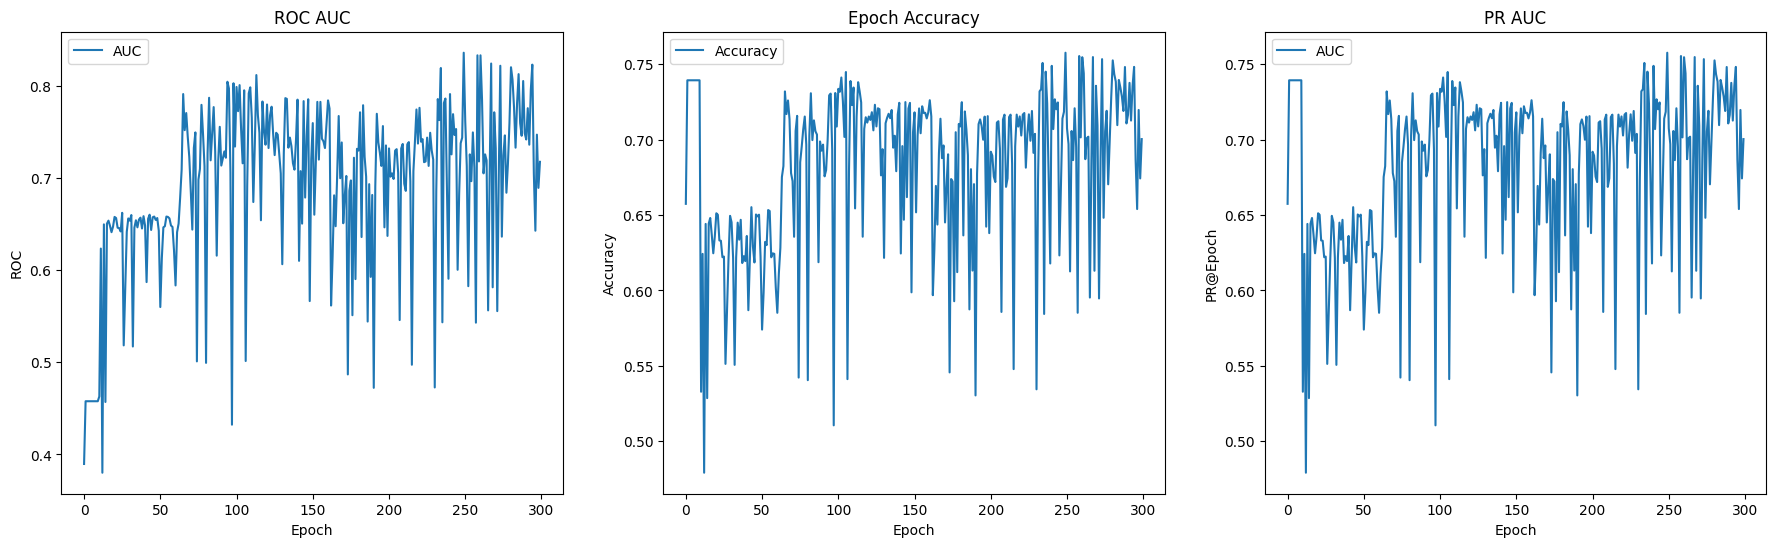

In [20]:
# Plotting epoch losses and accuracies 'ROC_AUC': [],
    # 'accuracy':[],
    # 'PR_AUC':[]
plt.figure(figsize=(22, 6))

plt.subplot(1, 3, 1)
plt.plot(history['ROC_AUC'], label='AUC')
plt.title('ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Accuracy')
plt.title('Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['PR_AUC'], label='AUC')
plt.title('PR AUC')
plt.xlabel('Epoch')
plt.ylabel('PR@Epoch')
plt.legend()


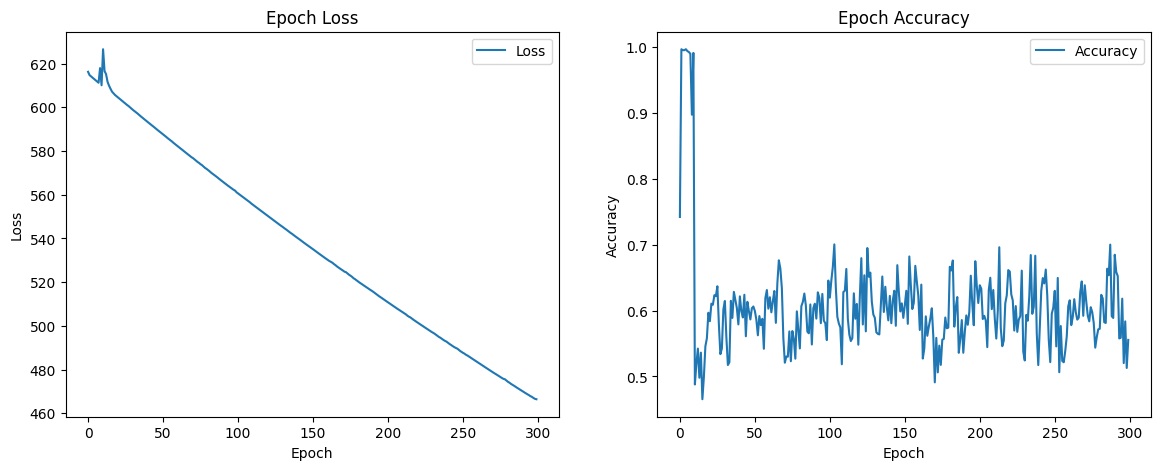

In [18]:
import matplotlib.pyplot as plt

# Plotting epoch losses and accuracies
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history['epoch_loss'], label='Loss')
plt.title('Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['epoch_accuracy'], label='Accuracy')
plt.title('Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# You can add more plots for batch-level data, rewards, thresholds, etc.


# Visual

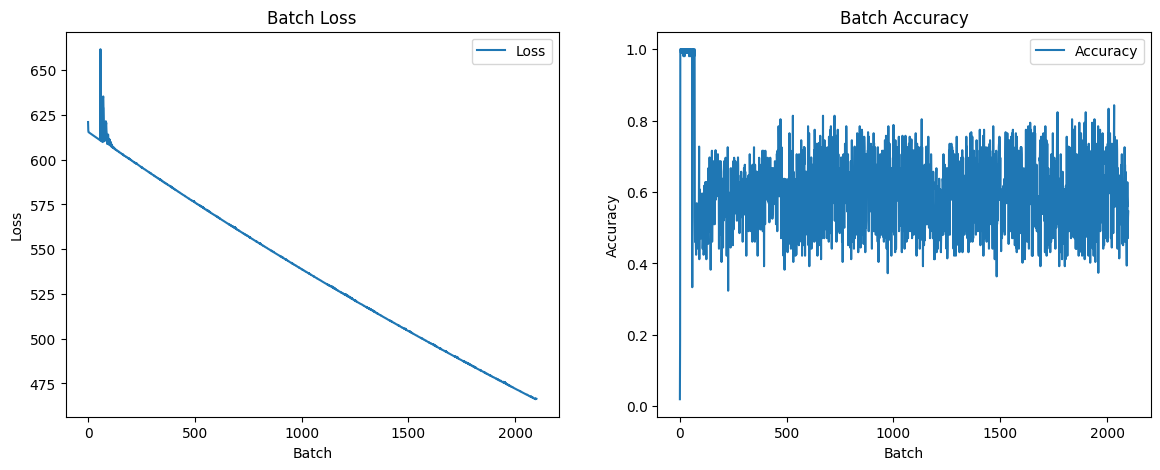

In [19]:
# Plotting epoch losses and accuracies
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history['batch_loss'], label='Loss')
plt.title('Batch Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['batch_accuracy'], label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()